# TASK 2

LGMVIP21 (SEPTEMBER)

# **Stock Market Prediction And Forecasting Using Stacked LSTM**


In [1]:
#Importing Libraries1
%time
import tensorflow as tf # This code has been tested with Tensorflow
import tensorflow_datasets as tfds
from tensorflow import keras

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [2]:
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
import datetime as dt
import urllib.request, json
import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense,LSTM

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Downloading the Data

In [3]:
stock_data = pd.read_csv("NSE-TATAGLOBAL.csv")

In [4]:
stock_data

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


### Data Exploration

In [5]:
stock_data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [6]:
stock_data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
stock_data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
stock_data.dropna(inplace = True, how = 'all')

In [9]:
stock_data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [10]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 143.1+ KB


In [11]:
# number of records in both stock Market Prediction and Forecasting Using Stacked LSTM
len(stock_data)

2035

In [12]:
# checking for null values in both the datasets
stock_data.isna().any()

Date                    False
Open                    False
High                    False
Low                     False
Last                    False
Close                   False
Total Trade Quantity    False
Turnover (Lacs)         False
dtype: bool

In [13]:
stock_data['Data'] = pd.to_datetime(stock_data['Date']).dt.normalize()

#flitering the important columns requried
stock_data = stock_data.filter(['Date', 'Close', 'Open', 'high', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_data.set_index('Date', inplace = True)

# sorting the data according to the index i.e Date'
stock_data = stock_data.sort_index(ascending = True, axis = 0)
stock_data

,Close,Open,Low
Date,,,
2010-07-21,121.55,122.10,121.05
2010-07-22,120.90,120.30,120.25
2010-07-23,120.65,121.80,120.25
2010-07-26,117.60,120.10,117.10
2010-07-27,118.65,117.60,112.00
...,...,...,...
2018-09-24,233.30,233.55,230.75
2018-09-25,236.10,233.30,232.00
2018-09-26,234.25,240.00,232.50


### Data Visualization

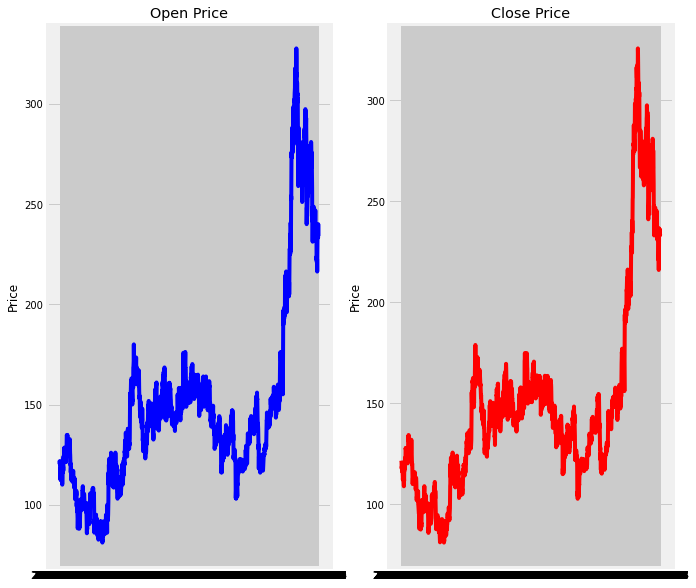

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(stock_data['Open'],'b')
plt.title("Open Price")
plt.ylabel("Price")

plt.subplot(1,2,2)
plt.plot(stock_data['Close'],'r')
plt.title("Close Price")
plt.ylabel("Price")
plt.show()

## 200 Exponential Moving Average (EMA) and 200 Simple Moving Average (SMA)

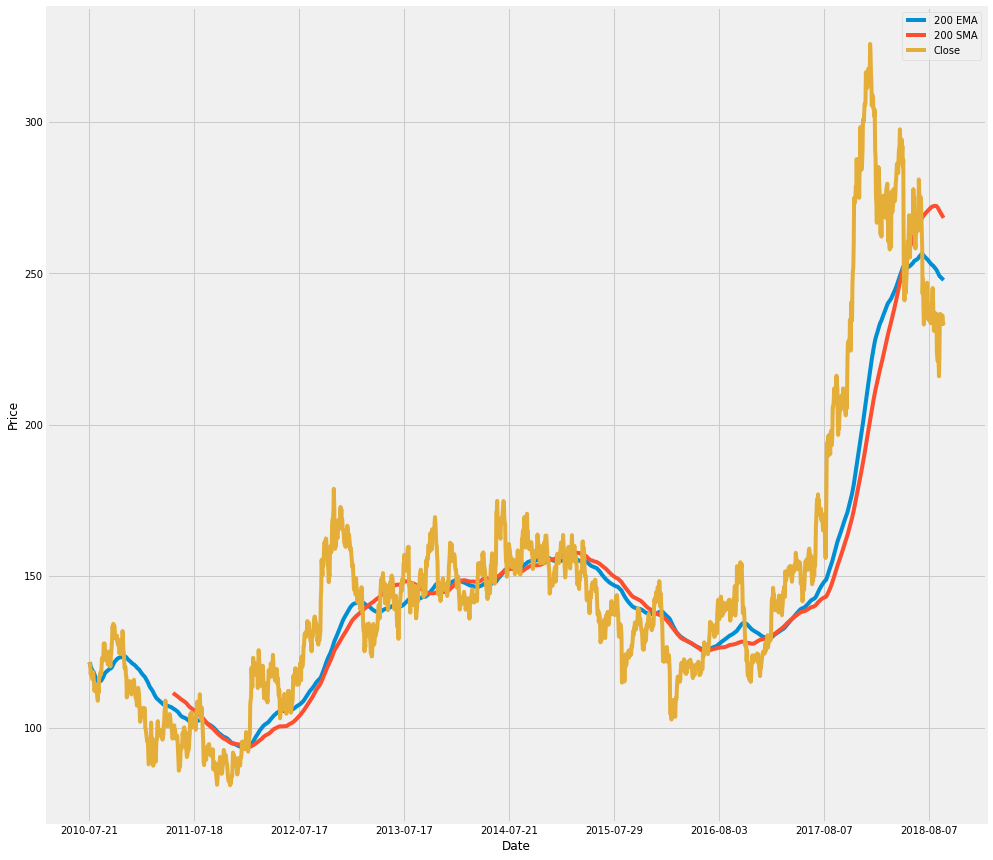

In [15]:
stock_data.ewm(span=200).mean()['Close'].plot(figsize = (15,15), label = '200 EMA')
stock_data.rolling(window=200).mean()['Close'].plot(figsize=(15,15), label = '200 SMA')
stock_data['Close'].plot(label = 'Close')
plt.legend()
plt.ylabel('Price')
plt.show()

In [16]:
training_orig = stock_data.loc[:, ['Close']]
training_orig

,Close
Date,
2010-07-21,121.55
2010-07-22,120.90
2010-07-23,120.65
2010-07-26,117.60
2010-07-27,118.65
...,...
2018-09-24,233.30
2018-09-25,236.10
2018-09-26,234.25


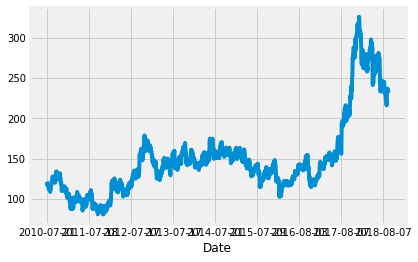

In [17]:
training_orig['Close'].plot()

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Close Price ($)')

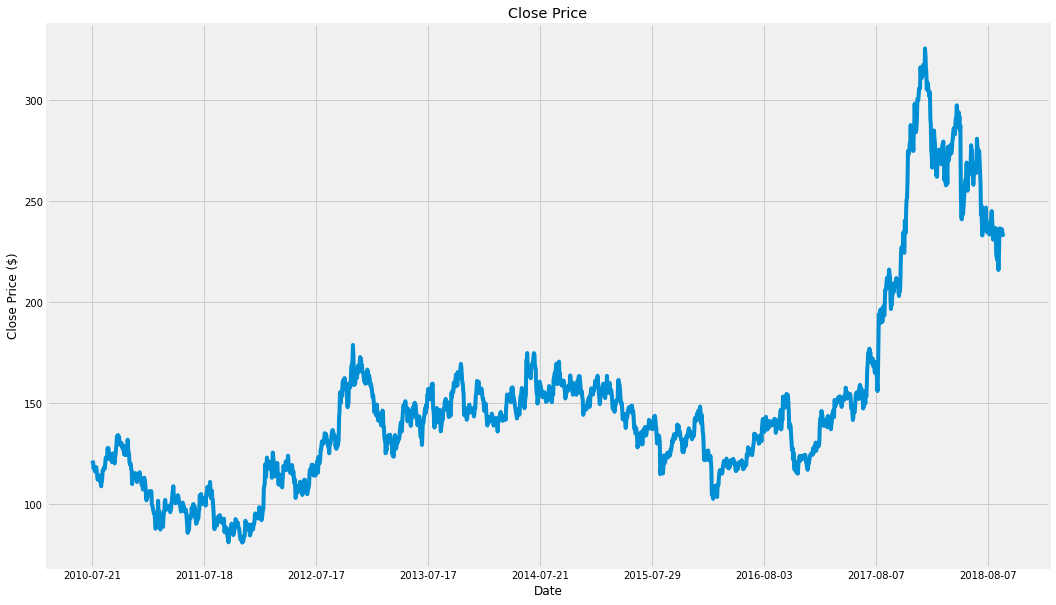

In [19]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot tittle x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

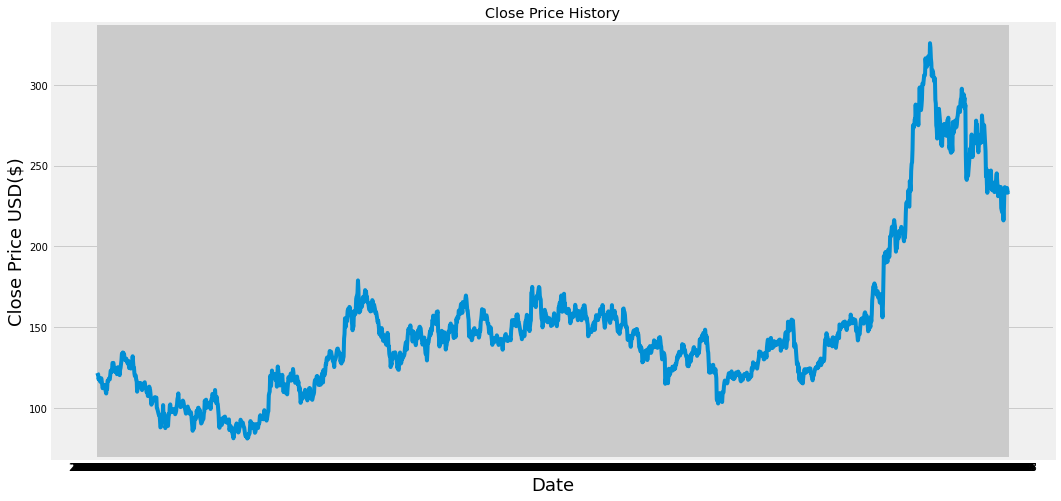

In [20]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize = 18)
plt.show()

In [21]:
data=stock_data.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

#scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

scaled_data

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.62622549],
       [0.62214052],
       [0.62418301]])

In [23]:
# Create training data set

train_data=scaled_data[0:training_data_len,:]

#split the data into x_train and y_train data sets

x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i <= 60:
        
        print(x_train)
        print(y_train)
        print()

[array([0.16584967, 0.16319444, 0.1621732 , 0.14971405, 0.15400327,
       0.15236928, 0.14562908, 0.14338235, 0.14848856, 0.15257353,
       0.14522059, 0.13521242, 0.12724673, 0.13031046, 0.12806373,
       0.13459967, 0.12908497, 0.13562092, 0.12377451, 0.1190768 ,
       0.11397059, 0.13112745, 0.12479575, 0.14603758, 0.14501634,
       0.14726307, 0.15196078, 0.1503268 , 0.14971405, 0.16156046,
       0.17177288, 0.1693219 , 0.16830065, 0.17238562, 0.19097222,
       0.18913399, 0.19138072, 0.18382353, 0.17544935, 0.17279412,
       0.16830065, 0.17034314, 0.17810458, 0.16973039, 0.16278595,
       0.17401961, 0.18035131, 0.17422386, 0.17116013, 0.16564542,
       0.16033497, 0.17381536, 0.17851307, 0.18811275, 0.19750817,
       0.21425654, 0.21098856, 0.21772876, 0.20445261, 0.21568627])]
[0.21282679738562094]



In [24]:
#convert train data to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)

#Reshape
x_train.shape

(1568, 60)

In [25]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1568, 60, 1)

In [26]:
# calculating 7 days moving avaerage
stock_data.rolling(7).mean().head(20)

,Close,Open,Low
Date,,,
2010-07-21,NaN,NaN,NaN
2010-07-22,NaN,NaN,NaN
2010-07-23,NaN,NaN,NaN
2010-07-26,NaN,NaN,NaN
2010-07-27,NaN,NaN,NaN
2010-07-28,NaN,NaN,NaN
2010-07-29,119.171429,118.914286,117.192857
2010-07-30,118.385714,118.114286,116.271429
2010-08-02,117.871429,117.685714,115.750000


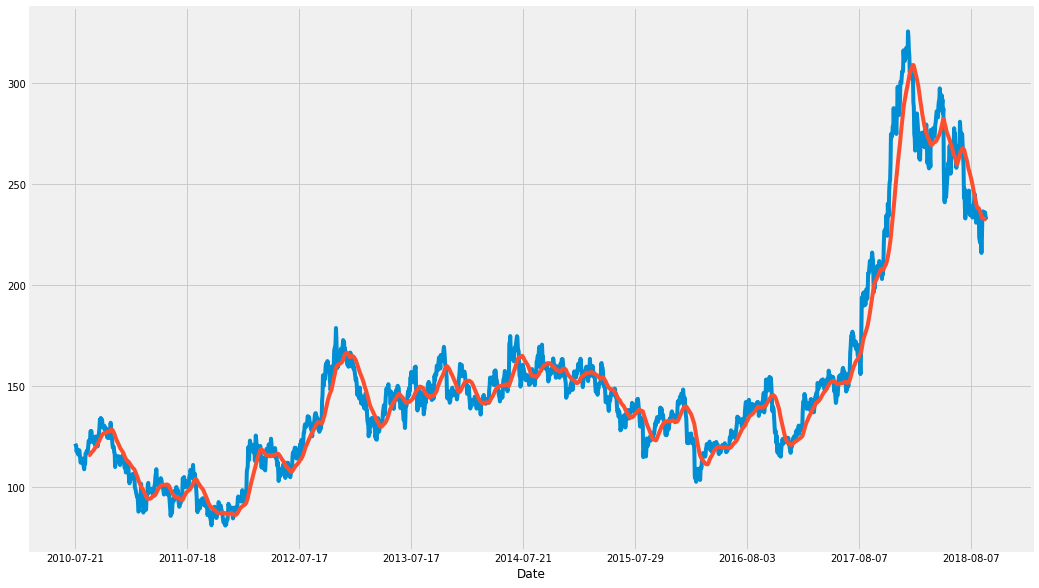

In [27]:
#setting figure size
plt.figure(figsize = (16,10))

# plotting the close price and a 30 days rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [28]:
# displaying stock_data
stock_data

,Close,Open,Low
Date,,,
2010-07-21,121.55,122.10,121.05
2010-07-22,120.90,120.30,120.25
2010-07-23,120.65,121.80,120.25
2010-07-26,117.60,120.10,117.10
2010-07-27,118.65,117.60,112.00
...,...,...,...
2018-09-24,233.30,233.55,230.75
2018-09-25,236.10,233.30,232.00
2018-09-26,234.25,240.00,232.50


In [29]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1627
Number of records in Test Data: 408


In [30]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
training = sc.fit_transform(np.array(training_orig['Close']).reshape(-1,1))
print(training.shape)

(2035, 1)


In [31]:
train_size = int(len(training)*0.65)

train = training[0:train_size]
test = training[train_size:]

print(train.shape)
print(test.shape)

(1322, 1)
(713, 1)


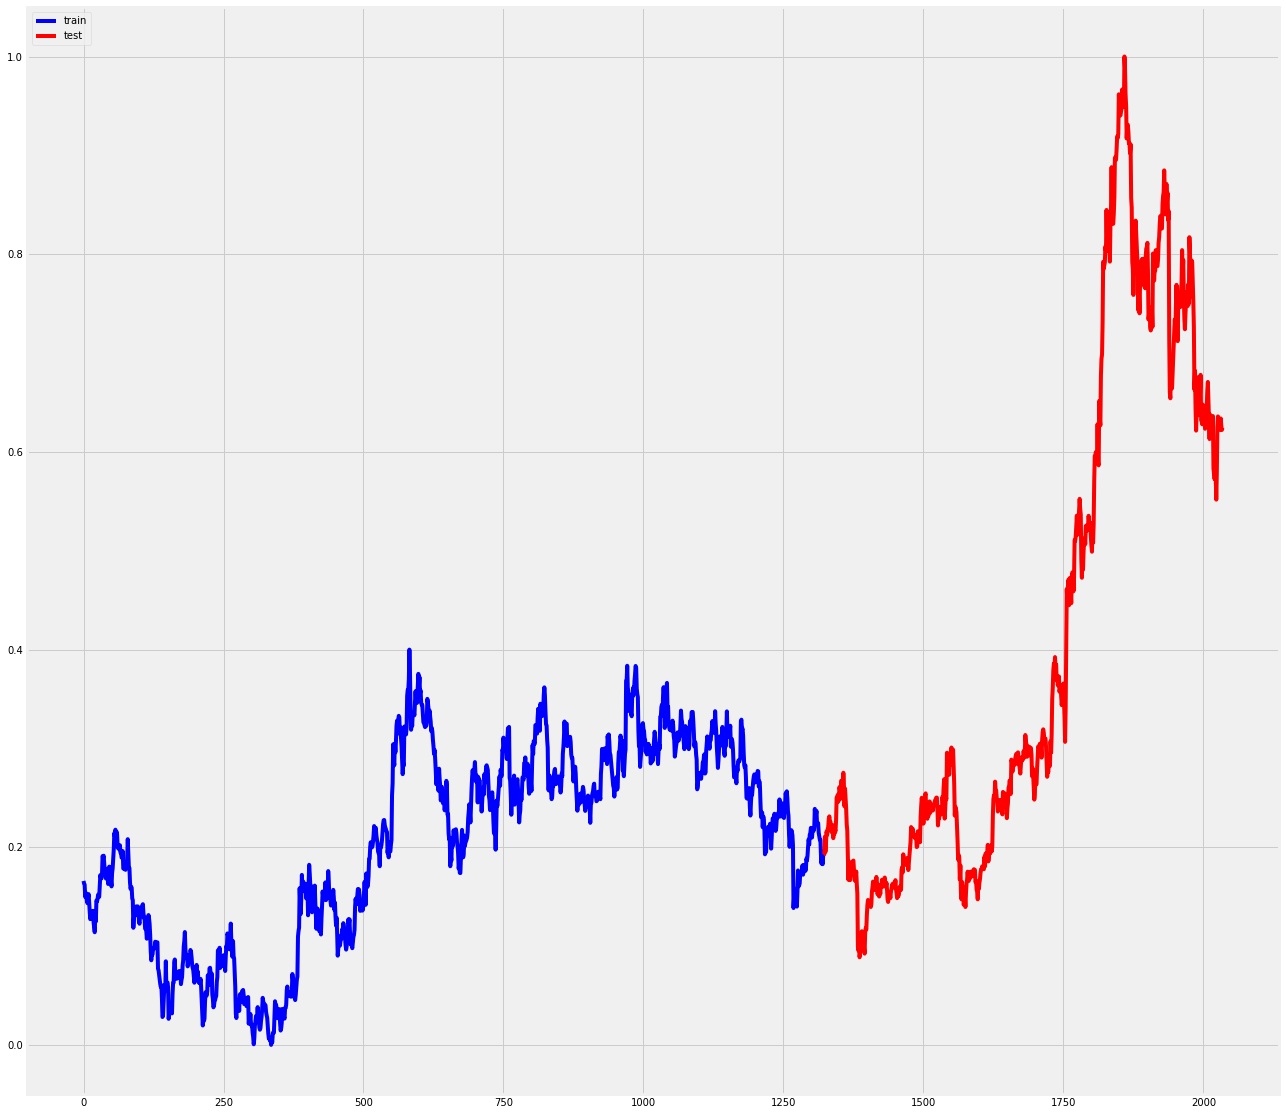

In [32]:
test_plot = np.empty_like(training)
test_plot[: , :] = np.nan
test_plot[len(train): , :] = test

plt.figure(figsize = (20,20))
plt.plot(train, 'blue', label = 'train')
plt.plot(test_plot, 'red', label='test')
plt.legend(loc='upper left')

In [33]:
def helper(dataset, timestep):
    x=[]
    y=[]
    for i in range(len(dataset)-timestep-1):
        x.append(dataset[i:(i+timestep),0])
        y.append(dataset[i+timestep, 0])
    return np.array(x), np.array(y)

In [34]:
x_train, y_train = helper(train,100)
x_test, y_test = helper(test,100)

In [35]:
x_train.shape, y_train.shape

((1221, 100), (1221,))

In [36]:
x_test.shape, y_test.shape

((612, 100), (612,))

In [37]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_test.shape

(612, 100, 1)

In [38]:
# build LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [39]:
#copile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
#train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1221/1221 [==============================] - 52s 40ms/step - loss: 8.7198e-04


In [41]:
# copile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
#create the testing dataset
#create a new array containing scaled values from index 1543 to 2003
test_data=scaled_data[training_data_len - 60:,:]
# create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [43]:
#convert the data to a numpy array
x_test=np.array(x_test)
#reshape
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [44]:
#get the models predicited price values
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

In [45]:
#Get the root mean squared error(RMSE)
rmse=np.sqrt( np.mean((predictions - y_test)**2))
rmse

23.639937501525022

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


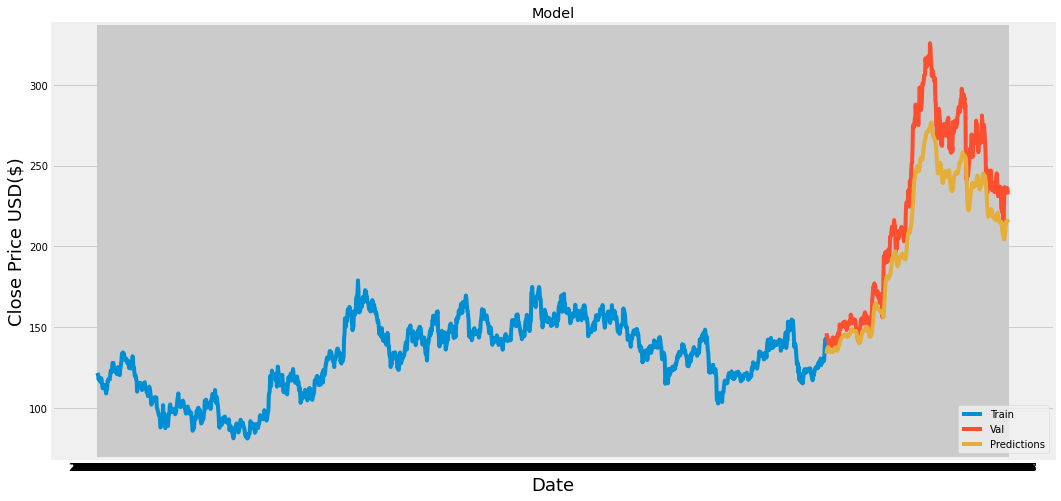

In [46]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'],loc='lower right')
plt.show()

In [47]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2017-02-08,146.15,133.551392
2017-02-09,143.90,135.543015
2017-02-10,143.95,136.803558
2017-02-13,141.95,137.478851
2017-02-14,141.20,137.426422
...,...,...
2018-09-24,233.30,215.712585
2018-09-25,236.10,215.690506
2018-09-26,234.25,215.710770
